## Using NLP to Analyzie Kaggle Forum Message
Using NLP techniques to analyze how Kaggle forum messages with silver/gold medals are different from the ones with bronze medals.

### Table of contents:

1. Introduction
2. Preprocessing of forum messages
3. Vectorization and visualization of forum messages
4. Distribution of medals in forums
5. Conclusion

In [1]:
import pandas as pd

from bs4 import BeautifulSoup
import re

import spacy

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import seaborn as sns

from collections import Counter

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import ColumnDataSource, Select, CustomJS
from bokeh.layouts import column
from bokeh.transform import factor_cmap, linear_cmap

output_notebook(hide_banner=True)

### Preprocessing Forum Messages

In [2]:
messages = pd.read_csv('./messages/ForumMessages.csv')
messages.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,27482,5134,33855,07/21/2013 07:42:21,NaN,<p>I agree with you in that training data shou...,NaN,NaN
1,27558,5134,381,07/23/2013 17:12:28,NaN,<p>Both train2 and train4 are artificial pairs...,NaN,NaN
2,27640,5134,114427,07/25/2013 07:59:56,NaN,<p>[quote=nor;27482]</p>\n<p>I agree with you ...,NaN,NaN
3,1,1,478,04/28/2010 23:13:08,NaN,<div>In response to a comment on the No Free H...,NaN,NaN
4,76,1,808,04/28/2010 23:13:08,NaN,Use a mixture of different models (linear regr...,NaN,NaN


In [3]:
messages.describe()

,Id,ForumTopicId,PostUserId,ReplyToForumMessageId,Medal
count,616833.000000,616833.000000,6.168330e+05,188293.000000,215650.000000
mean,358582.379503,59428.723773,1.132696e+06,421023.858194,2.862281
std,203109.249382,34410.123793,9.914894e+05,159926.922164,0.441248
min,1.000000,1.000000,6.200000e+01,1996.000000,1.000000
25%,184969.000000,30626.000000,3.015510e+05,284229.000000,3.000000
50%,355652.000000,57033.000000,8.929650e+05,412373.000000,3.000000
75%,532565.000000,88703.000000,1.723677e+06,557440.000000,3.000000
max,723353.000000,126739.000000,4.351467e+06,723308.000000,3.000000


In [4]:
messages.shape

(616833, 8)

In [5]:
messages = messages[messages.Message.notna()]
messages['PostDate'] = pd.to_datetime(messages['PostDate'], infer_datetime_format=True)
messages = messages.sort_values('PostDate')
messages.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
15,157,1,673,2010-04-28 23:13:08,NaN,<p>I'll briefly post a summary of my 20 hours ...,NaN,NaN
27,206,1,368,2010-04-28 23:13:08,NaN,The public leaderboard is only indicative beca...,NaN,NaN
25,205,1,728,2010-04-28 23:13:08,NaN,"Well, it's unfortunate that the contest turned...",NaN,NaN
23,198,1,1902,2010-04-28 23:13:08,NaN,Training and test data are clearly hand-picked...,NaN,NaN
17,159,1,1486,2010-04-28 23:13:08,NaN,"Hi Bruce, I appreciate you describing your app...",NaN,NaN


For cleaning messages from HTML tags I will be using the module BeautifulSoup. Calling it, however, for each individual message is very time consuming. Therefore, I create one string from all forum messages that are divided by a unique separator |sep|.

#### Analyzing Bronze Medals

In [6]:
messages_str = ' |sep| '.join(messages.Message.tolist())

messages_str = re.sub(r'<code>.*?</code>', '', messages_str, flags=re.DOTALL)
messages_str = re.sub('<-', '', messages_str)

messages_str = BeautifulSoup(messages_str, 'lxml').get_text()

messages_str = re.sub(r'http\S+', '', messages_str)
messages_str = re.sub(r'@\S+', '', messages_str)

messages['Message'] = messages_str.split(' |sep| ')

messages.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
15,157,1,673,2010-04-28 23:13:08,NaN,I'll briefly post a summary of my 20 hours (or...,NaN,NaN
27,206,1,368,2010-04-28 23:13:08,NaN,The public leaderboard is only indicative beca...,NaN,NaN
25,205,1,728,2010-04-28 23:13:08,NaN,"Well, it's unfortunate that the contest turned...",NaN,NaN
23,198,1,1902,2010-04-28 23:13:08,NaN,Training and test data are clearly hand-picked...,NaN,NaN
17,159,1,1486,2010-04-28 23:13:08,NaN,"Hi Bruce, I appreciate you describing your app...",NaN,NaN


#### Vectorization and Visualization
>  In this kernel I will be using the vectorization method called word embedding. It encodes each word with a vector taken from a large dictionary of word-vector pairs. These dictionaries are obtained from the neural networks that were trained on a lot of documents, and can be easily found online. The big advantage of the word embedding method is that contextually similar words have similar word vectors. This approach will allow us to compare forum messages with each other.

In [7]:
corpus = messages[messages.Medal == 3].Message.tolist()[-1000:]
corpus[-5:]

["Referring to the link on scientific misconduct, I feel that fabrication and falsification are factors that are largely aimed at doctorate students and professors whom are looking to get a research paper published in a journal so that they may formally graduate with a PhD. It is to my understanding that PhD students are often times required to complete research in some sub-field under the guidance of a university professor and have it published in a journal. After doing so they may receive their diploma and the title of PhD. Additionally, the professor will have gained another paper with their name on it allowing them the opportunity to continue working at the university and eventually gain tenure.\nThose to me are actually quite strong incentives which could make an ordinary person do things that they normally wouldn't do (i.e., cheat). By falsifying research or fabricating data, people can then gain some material benefit (e.g., PhD students can then get a high-paying job with their 

> I'm using built-in SpaCy model for the English language 'en_core_web_lg' that can assign word vectors, POS tags, dependency parse and named entities. Since named entities recognition 'ner' is not required in this kernel I have dsiabled it to speed up processing time.

In [8]:
nlp = spacy.load('en_core_web_lg', disable=['ner'])

In [12]:
# tokenization
batch = nlp.pipe(corpus)
corpus_tok = []
for doc in batch:
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.has_vector and not token.is_stop]
    tokens_str = ' '.join(tokens)
    if tokens_str != '':
        corpus_tok.append(tokens_str)

corpus_tok[-5:]

['refer link scientific misconduct feel fabrication falsification factor largely aim doctorate student professor look research paper publish journal formally graduate understanding phd student time require complete research sub field guidance university professor publish journal receive diploma title additionally professor gain paper allow opportunity continue work university eventually gain tenure actually strong incentive ordinary person thing normally cheat falsify research fabricate datum people gain material benefit phd student high pay job title professor increasingly high salary etc sort environment think dangerous definitely need address accordingly reproducibility crisis possibly scientific misconduct blame understand institutional problem hide ivory tower academia regard connection topic ethic datum science machine learning feel important point plagiarism think tech field programming require datum science machine learning software engineering etc notion plagiarism different f

In [13]:
# vectorization
batch_tok = nlp.pipe(corpus_tok)
X = []
for doc in batch_tok:
    X.append(doc.vector)

In [14]:
# dimensional reduction
X_emb = TSNE(random_state=0).fit_transform(X)
df = pd.DataFrame(X_emb, columns=['x','y'])
df.head()

,x,y
0,0.833855,1.373703
1,16.688887,7.187163
2,25.728703,-0.584720
3,-20.983469,-6.546701
4,-0.560589,-10.146518


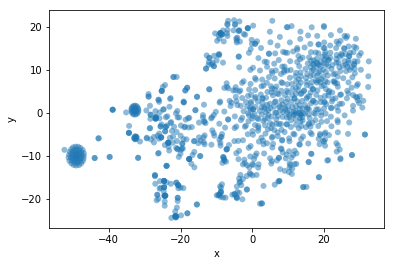

In [17]:
# visualization
sns.scatterplot('x', 'y', data=df, edgecolor='none', alpha=0.5)

> It looks like there are at least 3 clusters present here. Let's use KMeans() to identify these clusters and add the cluster labels to the DataFrame.

In [18]:
model = KMeans(n_clusters=3)
df['Label'] = model.fit_predict(X_emb)
df['Tokens'] = corpus_tok
df.head()

,x,y,Label,Tokens
0,0.833855,1.373703,0,hi thank suggestion certificate appear profile...
1,16.688887,7.187163,1,hi sabin depend problem type feature technical...
2,25.728703,-0.584720,1,try subset video work find total number differ...
3,-20.983469,-6.546701,2,thank advice important thank reading
4,-0.560589,-10.146518,0,great similar code base love pull similar imag...


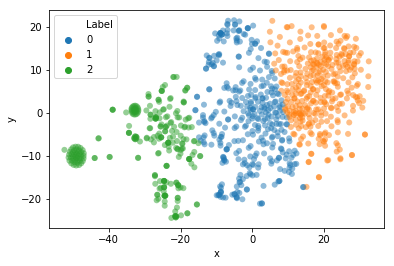

In [19]:
# scatter plot of labeled clusters
palette = sns.color_palette(n_colors=3)
sns.scatterplot('x','y', data=df, edgecolor='none', alpha=0.5, hue='Label', palette=palette)

In [20]:
# most common words of all 3 clusters

cluster0 = ' '.join(df[df.Label == 0].Tokens.tolist())
words0 = Counter(cluster0.split())
words0.most_common(10)

[('thank', 156),
 ('kernel', 82),
 ('good', 67),
 ('great', 66),
 ('notebook', 54),
 ('work', 50),
 ('share', 37),
 ('visualization', 35),
 ('nice', 34),
 ('lot', 33)]

In [22]:
cluster1 = ' '.join(df[df.Label == 1].Tokens.tolist())
words1 = Counter(cluster1.split())
words1.most_common(10)

[('datum', 105),
 ('model', 104),
 ('day', 76),
 ('work', 75),
 ('good', 71),
 ('competition', 64),
 ('think', 62),
 ('solution', 61),
 ('use', 60),
 ('data', 60)]

In [23]:
cluster2 = ' '.join(df[df.Label == 2].Tokens.tolist())
words2 = Counter(cluster2.split())
words2.most_common(10)

[('thank', 192),
 ('share', 58),
 ('work', 47),
 ('great', 45),
 ('nice', 39),
 ('sharing', 28),
 ('good', 27),
 ('job', 14),
 ('informative', 11),
 ('lot', 10)]

#### Interactive visualization of the messages and its tokens.

In [24]:
s = ColumnDataSource(df)

p = figure(plot_width=600, plot_height=400, toolbar_location=None, tools=['hover'], tooltips='@Tokens')

cmap = linear_cmap('Label', palette=palette.as_hex(), low=df.Label.min(), high=df.Label.max())
p.circle('x', 'y', source=s, color=cmap)

tokens_all = ' '.join(df.Tokens.tolist()).split()
options = sorted(set(tokens_all))
options.insert(0, 'Please choose...')
select = Select(value='Please choose...', options=options)

def callback(s=s, window=None):
    indices = [i for i, x in enumerate(s.data['Tokens']) if cb_obj.value in x]
    s.selected.indices = indices
    s.change.emit()
    
select.js_on_change('value', CustomJS.from_py_func(callback))
    
show(column(select, p))

#### Analyzing Silver/Gold Medals

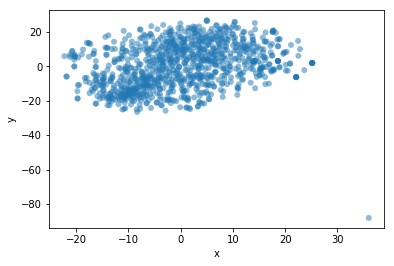

In [25]:
corpus = messages[(messages.Medal == 1) | (messages.Medal == 2)].Message.tolist()[-1000:]

batch = nlp.pipe(corpus)
corpus_tok = []
for doc in batch:
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.has_vector and not token.is_stop]
    tokens_str = ' '.join(tokens)
    if tokens_str != '':
        corpus_tok.append(tokens_str)

batch_tok = nlp.pipe(corpus_tok)
X = []
for doc in batch_tok:
    X.append(doc.vector)
    
X_emb = TSNE(random_state=0).fit_transform(X)

df = pd.DataFrame(X_emb, columns=['x', 'y'])
df['Tokens'] = corpus_tok

sns.scatterplot('x', 'y', data=df, edgecolor='none', alpha=0.5)

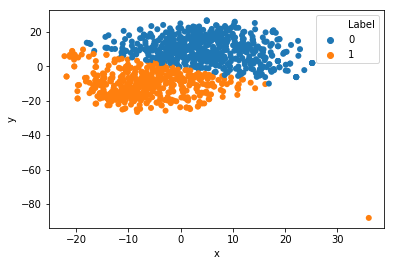

In [27]:
model = KMeans(n_clusters=2)
df['Label'] = model.fit_predict(X_emb)

palette = sns.color_palette(n_colors=2)
sns.scatterplot('x','y', data=df, edgecolor='none', hue='Label', palette=palette)

In [29]:
cluster0 = ' '.join(df[df.Label == 0].Tokens.tolist())
words0 = Counter(cluster0.split())
words0.most_common(10)

[('competition', 441),
 ('solution', 204),
 ('work', 177),
 ('time', 170),
 ('datum', 166),
 ('thank', 160),
 ('team', 152),
 ('good', 149),
 ('like', 135),
 ('day', 133)]

In [30]:
cluster1 = ' '.join(df[df.Label == 1].Tokens.tolist())
words1 = Counter(cluster1.split())
words1.most_common(10)

[('model', 844),
 ('datum', 471),
 ('feature', 403),
 ('lb', 320),
 ('competition', 303),
 ('time', 281),
 ('train', 264),
 ('score', 257),
 ('good', 248),
 ('kernel', 242)]

In [31]:
s = ColumnDataSource(df)

p = figure(plot_width=600, plot_height=400, toolbar_location=None, tools=['hover'], tooltips='@Tokens')

cmap = linear_cmap('Label', palette=palette.as_hex(), low=df.Label.min(), high=df.Label.max())
p.circle('x', 'y', source=s, color=cmap)

tokens_all = ' '.join(df.Tokens.tolist()).split()
options = sorted(set(tokens_all))
options.insert(0, 'Please choose...')
select = Select(value='Please choose...', options=options)

def callback(s=s, window=None):
    indices = [i for i, x in enumerate(s.data['Tokens']) if cb_obj.value in x]
    s.selected.indices = indices
    s.change.emit()
    
select.js_on_change('value', CustomJS.from_py_func(callback))
    
show(column(select, p))

As an interim conclusion, the messages with silver/gold medals tend to focus more on improving competitions scores and brainstorming new models while the messages with bronze medals are mostly about appreciation of other people's work.

### Distribution of Medals in Forums

In [32]:
topics = pd.read_csv('./messages/ForumTopics.csv')
topics.head()

,Id,ForumId,KernelId,LastForumMessageId,FirstForumMessageId,CreationDate,LastCommentDate,Title,IsSticky,TotalViews,Score,TotalMessages,TotalReplies
0,1,1,NaN,212,1.0,04/28/2010 23:13:08,04/28/2010 23:13:08,A few techniques you might try:,False,9405,1,19,18
1,2,1,NaN,4,2.0,04/29/2010 15:48:46,04/29/2010 15:48:46,Question regarding algorithms used,False,2185,0,3,2
2,3,1,NaN,41,5.0,04/30/2010 14:32:29,04/30/2010 14:32:29,Question about data,False,2121,0,3,2
3,4,1,NaN,13,6.0,04/30/2010 15:40:57,04/30/2010 15:40:57,Biased sets,False,2780,1,4,3
4,5,1,NaN,12,10.0,05/01/2010 11:00:57,05/01/2010 11:00:57,Non-standard nucleotide codings,False,2045,0,2,1


In [33]:
forums = pd.read_csv('./messages/Forums.csv')
forums.head()

,Id,ParentForumId,Title
0,1,8.0,Predict HIV Progression
1,2,8.0,Forecast Eurovision Voting
2,3,8.0,World Cup 2010 - Take on the Quants
3,4,8.0,INFORMS Data Mining Contest 2010
4,5,NaN,Active Competitions


In [36]:
# merge select features from messages and topics based on ForumTopicId.
df1 = pd.merge(messages[['ForumTopicId', 'PostDate', 'Medal']], topics[['Id', 'ForumId','Title']],
               left_on='ForumTopicId', right_on='Id')
df1 = df1.drop(['ForumTopicId', 'Id'], axis=1)
df1.head()

,PostDate,Medal,ForumId,Title
0,2010-04-28 23:13:08,NaN,1,A few techniques you might try:
1,2010-04-28 23:13:08,NaN,1,A few techniques you might try:
2,2010-04-28 23:13:08,NaN,1,A few techniques you might try:
3,2010-04-28 23:13:08,NaN,1,A few techniques you might try:
4,2010-04-28 23:13:08,NaN,1,A few techniques you might try:


In [38]:
# merge the resulting DataFrame and forums based on ForumId.

df2 = pd.merge(df1, forums[['Id', 'Title']], left_on='ForumId', right_on='Id')
df2 = df2.drop(['ForumId', 'Id'], axis=1)
df2.head()

,PostDate,Medal,Title_x,Title_y
0,2010-04-28 23:13:08,NaN,A few techniques you might try:,Predict HIV Progression
1,2010-04-28 23:13:08,NaN,A few techniques you might try:,Predict HIV Progression
2,2010-04-28 23:13:08,NaN,A few techniques you might try:,Predict HIV Progression
3,2010-04-28 23:13:08,NaN,A few techniques you might try:,Predict HIV Progression
4,2010-04-28 23:13:08,NaN,A few techniques you might try:,Predict HIV Progression


Let's extract all messages from 2019 that got bronze medals and the ones that got silver/gold medals. Due to the large number of forum titles, only the top-10 forums with most medals are selected.

In [52]:
bronze = df2[(df2.Medal == 3) & (df2.PostDate > '2019-01-01 00:00:00')]
bronze_gr = bronze.groupby('Title_x').count()
bronze_ind = bronze_gr.sort_values('Medal')[-10:].index.values
bronze = bronze[bronze.Title_x.isin(bronze_ind)]

silver_gold = df2[((df2.Medal == 1) | (df2.Medal == 2)) & (df2.PostDate > '2019-01-01 00:00:00')]
silver_gold_gr = silver_gold.groupby('Title_y').count()
silver_gold_ind = silver_gold_gr.sort_values('Medal')[-10:].index.values
silver_gold = silver_gold[silver_gold.Title_x.isin(silver_gold_ind)]

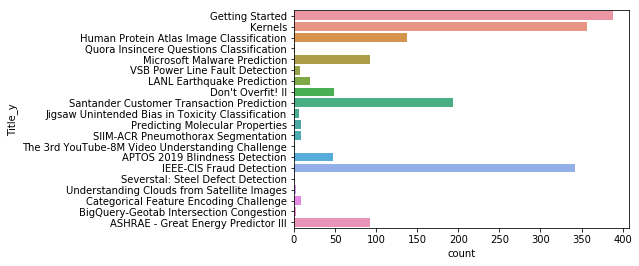

In [53]:
sns.countplot(y='Title_y', data=bronze)

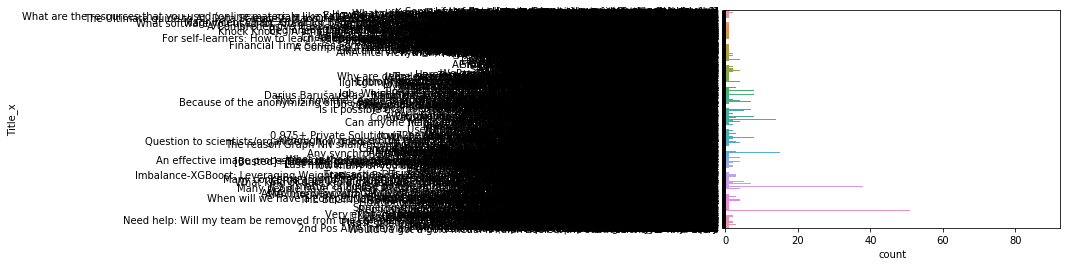

In [50]:
sns.countplot(y='Title_x', data=silver_gold)


    - Messages with bronze medals mostly show appreciation of other people's work.
    - Messages with silver/gold medals mostly focus on improving competition results.